In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = {
    'Model': [
        'OptBert (full data)', 'OptBert (50% data)', 'OptBert (30% data)', 'RXNFP',
        'OptBert (10% data)', 'OptBert (10% data, soft negative pairs)', 'DRFP',
        'Pre-trained Bert'
    ],
    'Accuracy': [0.9618, 0.9618, 0.9616, 0.9579, 0.9563, 0.9446, 0.9269, 0.8328],
    'Precision (Macro)': [0.8889, 0.8882, 0.8957, 0.8747, 0.9020, 0.8913, 0.8903, 0.7646],
    'Recall (Macro)': [0.8761, 0.8757, 0.8800, 0.8642, 0.8747, 0.8595, 0.8603, 0.7221],
    'F1-Score (Macro)': [0.8759, 0.8757, 0.8813, 0.8625, 0.8812, 0.8679, 0.8675, 0.7330],
    'Precision (Weighted)': [0.9619, 0.9618, 0.9614,0.9581, 0.9564, 0.9447, 0.9279, 0.8325],
    'Recall (Weighted)': [0.9618, 0.9618, 0.9614, 0.9580, 0.9564, 0.9447, 0.9270, 0.8328],
    'F1-Score (Weighted)': [0.9616, 0.9616, 0.9612, 0.9578, 0.9561, 0.9444, 0.9266, 0.8319]
}

In [3]:
df = pd.DataFrame(data)
df

,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,OptBert (full data),0.9618,0.8889,0.8761,0.8759,0.9619,0.9618,0.9616
1,OptBert (50% data),0.9618,0.8882,0.8757,0.8757,0.9618,0.9618,0.9616
2,OptBert (30% data),0.9616,0.8957,0.8800,0.8813,0.9614,0.9614,0.9612
3,RXNFP,0.9579,0.8747,0.8642,0.8625,0.9581,0.9580,0.9578
4,OptBert (10% data),0.9563,0.9020,0.8747,0.8812,0.9564,0.9564,0.9561
5,"OptBert (10% data, soft negative pairs)",0.9446,0.8913,0.8595,0.8679,0.9447,0.9447,0.9444
6,DRFP,0.9269,0.8903,0.8603,0.8675,0.9279,0.9270,0.9266
7,Pre-trained Bert,0.8328,0.7646,0.7221,0.7330,0.8325,0.8328,0.8319


In [4]:
y_pred_val_1nn = np.load('../ReactionClassification_2024/data/PreBertFP/y_pred_val_1nn.npy')
X_val = np.load('data/PreBertFP/X_val_PreBertFP.npy',allow_pickle=True)

In [5]:
train = pd.read_csv('../ReactionClassification_2024/data/train.csv', delimiter=',')
val = pd.read_csv('../ReactionClassification_2024/data/val.csv', delimiter=',')
test = pd.read_csv('../ReactionClassification_2024/data/test.csv', delimiter=',')

In [6]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [7]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [8]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [9]:
val_df = val

comparison_results = []
for true_val, pred_val in zip(y_val, y_pred_val_1nn.flatten()):
    classification_result = 'correct' if true_val == pred_val else 'wrong'
    comparison_results.append([true_val, pred_val, classification_result])

# Convert the comparison results to a DataFrame
comparison_df = pd.DataFrame(comparison_results, columns=['CLASS-ID', 'Predicted', 'Result'])

In [11]:
wrong_df = comparison_df

In [12]:
wrong_df_merged_actual = wrong_df.merge(df_class, how='left', left_on='CLASS-ID', right_on='CLASS-ID')

wrong_df_merged_actual = wrong_df_merged_actual.rename(columns={
    'TRANSFORM_ID': 'Actual_TRANSFORM_ID',
    'TRANSFORM_NAME': 'Actual_TRANSFORM_NAME'
})

wrong_df_merged_full = wrong_df_merged_actual.merge(df_class, how='left', left_on='Predicted', right_on='CLASS-ID', suffixes=('_Actual', '_Predicted'))

wrong_df_transformed = wrong_df_merged_full[['CLASS-ID_Actual', 'Actual_TRANSFORM_ID', 'Actual_TRANSFORM_NAME', 'Predicted', 'TRANSFORM_ID', 'TRANSFORM_NAME']]
wrong_df_transformed.columns = ['CLASS-ID', 'Actual_TRANSFORM_ID', 'Actual_TRANSFORM_NAME', 'Predicted', 'Predicted_TRANSFORM_ID', 'Predicted_TRANSFORM_NAME']

In [13]:
wrong_df_transformed['Actual_SUPER_TRANSFORM_ID'] = wrong_df_transformed['Actual_TRANSFORM_ID'].str.extract(r'\((.*?)\)')
wrong_df_transformed['Predicted_SUPER_TRANSFORM_ID'] = wrong_df_transformed['Predicted_TRANSFORM_ID'].str.extract(r'\((.*?)\)')

/tmp/ipykernel_2611253/1566809022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_df_transformed['Actual_SUPER_TRANSFORM_ID'] = wrong_df_transformed['Actual_TRANSFORM_ID'].str.extract(r'\((.*?)\)')
/tmp/ipykernel_2611253/1566809022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_df_transformed['Predicted_SUPER_TRANSFORM_ID'] = wrong_df_transformed['Predicted_TRANSFORM_ID'].str.extract(r'\((.*?)\)')


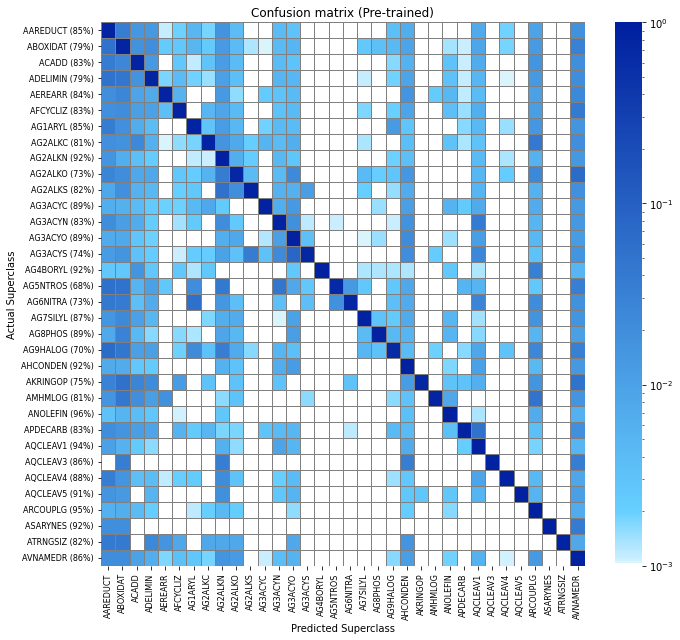

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Assuming `wrong_df_transformed` is your dataframe
# Load your dataframe here, for example:
# wrong_df_transformed = pd.read_csv('path_to_your_file.csv')

# Generate the confusion matrix
conf_matrix = confusion_matrix(wrong_df_transformed['Actual_SUPER_TRANSFORM_ID'], 
                               wrong_df_transformed['Predicted_SUPER_TRANSFORM_ID'])

# Convert confusion matrix to dataframe for better plotting
labels = sorted(wrong_df_transformed['Actual_SUPER_TRANSFORM_ID'].unique())
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_df.div(conf_matrix_df.sum(axis=1), axis=0)

# Calculate the accuracy for each superclass
accuracy_per_class = conf_matrix_df.to_numpy().diagonal() / conf_matrix_df.sum(axis=1)
accuracy_labels = [f'{label} ({accuracy:.0%})' for label, accuracy in zip(labels, accuracy_per_class)]
accuracy_df = pd.DataFrame(accuracy_per_class, index=labels, columns=['Accuracy'])

# Create a custom colormap with more contrast at the lower end
colors = [
    (0.0, "#ffffff"),
    (0.001, "#e0f7fa"),  # Very light blue
    (0.01, "#ccefff"),
    (0.1, "#66cfff"),
    (1.0, "#001f9f")  # Very dark blue
]
cmap_name = 'custom_heatmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Plotting the heatmap
plt.figure(figsize=(10, 9))
heatmap = sns.heatmap(conf_matrix_normalized, annot=False, fmt=".2f", cmap=cm, cbar=True, linewidths=.5, linecolor='grey', norm=LogNorm(vmin=0.001, vmax=1))
plt.title('Confusion matrix (Pre-trained)')
plt.xlabel('Predicted Superclass')
plt.ylabel('Actual Superclass')

# Set y-axis labels with accuracy
heatmap.set_yticks(np.arange(len(labels)) + 0.5)
heatmap.set_yticklabels(accuracy_labels, rotation=0, fontsize=8)

# Adjust x-axis labels
plt.xticks(rotation=90, fontsize=8)

# Add a color bar with the defined color palette
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()